# Desafio Nº3 - Entrenamiento de Modelo de Lenguaje

**Integrantes**:
- Santiago Belen. 

### Consigna
**1**. Seleccionar un corpus de texto sobre el cual entrenar el modelo de lenguaje.

**2**. Realizar el pre-procesamiento adecuado para tokenizar el corpus, estructurar el dataset y separar entre datos de entrenamiento y validación.

**3**. Proponer arquitecturas de redes neuronales basadas en unidades recurrentes para implementar un modelo de lenguaje.

**4**. Con el o los modelos que consideren adecuados, generar nuevas secuencias a partir de secuencias de contexto con las estrategias de greedy search y beam search determístico y estocástico. En este último caso observar el efecto de la temperatura en la generación de secuencias.

In [1]:
# Librerías
import pandas as pd
import numpy as np
import random
import re
import string
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow import keras
from scipy.special import softmax  
from tensorflow.keras.utils import Sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, LSTM, GRU, Dense
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import load_model
from collections import Counter
from wordcloud import WordCloud
pd.set_option('display.max_colwidth', None)


In [2]:
np.random.seed(42)

# Datos

Se utilizará como dataset el corpus del trabajo practico 2. El mismo representa transcripciones médicas, en formato CSV, y contiene **4,999 documentos**. **[MTSamples](https://www.kaggle.com/datasets/tboyle10/medicaltranscriptions/download)**

- Para entrenar el modelo del lenguaje a nivel de caracter, se usará la información contenida en la columna `transcription`.

- Para reducir la variabilidad tematica, se decidio trabajar exclusivamente con la especialidad `Surgery`. Esta categoria **1103** registros, con **3.45 millones de caracteres en total**. 

- Por motivos computacionales y de tiempo de entrenamiento, se decide reducir el tamaño del corpus `Surgery` a **100.000 mil caracteres**.


### Estructura del dataset

| Columna           | Descripción                                                                 |
|-------------------|-----------------------------------------------------------------------------|
| `description`      | Breve descripción del caso o procedimiento.                                |
| `medical_specialty`| Especialidad médica asociada a la transcripción.                           |
| `sample_name`      | Nombre de la muestra.                                                      |
| `transcription`    | Transcripción médica completa del caso (historia clínica, examen, etc.).   |
| `keywords`         | Palabras clave separadas por comas relacionadas con la transcripción.      |
| `Unnamed: 0`       | Índice.   

# 1. Carga y selección del corpus

In [3]:
# Cargar el dataset
df = pd.read_csv("mtsamples.csv")

# Limpiar espacios en blanco en los nombres de especialidad
df["medical_specialty"] = df["medical_specialty"].astype(str).str.strip()

# Filtrar registros con especialidad 'Surgery'
df_surgery = df[df["medical_specialty"] == "Surgery"]

# Mostrar cuántos registros hay
print("Cantidad de registros con especialidad 'Surgery':", len(df_surgery))

# Construir el corpus como una gran cadena de texto (a minúsculas)
corpus = " ".join(df_surgery["transcription"].astype(str).tolist()).lower()

# Mostrar tamaño en millones de caracteres
print(f"Cantidad total de caracteres en el corpus 'Surgery': {len(corpus)/1e6:.2f} millones")

# Cortar el corpus a los primeros 100,000 mil caracteres
corpus = corpus[:100000]
print("\nLongitud final del corpus 'Surgery':", len(corpus))

# Mostrar un ejemplo de contenido
print("\nPrimeros 500 caracteres de las dos primeras transcripciones:")
for i in range(2):
    print(f"\n--- Transcripción {i+1} ---")
    print(df_surgery["transcription"].iloc[i][:500])

Cantidad de registros con especialidad 'Surgery': 1103
Cantidad total de caracteres en el corpus 'Surgery': 3.45 millones

Longitud final del corpus 'Surgery': 100000

Primeros 500 caracteres de las dos primeras transcripciones:

--- Transcripción 1 ---
PREOPERATIVE DIAGNOSES:,1.  Hallux rigidus, left foot.,2.  Elevated first metatarsal, left foot.,POSTOPERATIVE DIAGNOSES:,1.  Hallux rigidus, left foot.,2.  Elevated first metatarsal, left foot.,PROCEDURE PERFORMED:,1.  Austin/Youngswick bunionectomy with Biopro implant.,2.  Screw fixation, left foot.,HISTORY: , This 51-year-old male presents to ABCD General Hospital with the above chief complaint.  The patient states that he has had degenerative joint disease in his left first MPJ for many year

--- Transcripción 2 ---
PREOPERATIVE DIAGNOSIS: , Secondary capsular membrane, right eye.,POSTOPERATIVE DIAGNOSIS: , Secondary capsular membrane, right eye.,PROCEDURE PERFORMED: , YAG laser capsulotomy, right eye.,INDICATIONS: , This patient ha

# 2. Preprocesamiento y tokenización.
Dadas las caracteristicas particulares del lenguaje medico, se decidio realizar un pre procesamiento dirigido. 
- Para preservar información relevante sin introducir ruido innecesario, se definio un conjunto limitado de caracteres validos (letras minúsculas, números y algunos signos de puntuación básicos como . , - ' % /). Esto busca tambien facilitiar el entrenamiento y la generalizacion, reduciendo el tamaño del vocabulario a un conjunto de **43 caracteres**. 
- Se tokenizó el texto mapeando cada carácter a un índice único (char2idx). 

In [4]:
# Preprocesamiento y tokenización
# Caracteres a conservar
caracteres_a_conservar = (
    list(string.ascii_lowercase) +
    list(string.digits) +
    [' ', '.', ',', '-', "'", '%', '/']
)

# Limpiar el corpus
corpus = "".join([ch for ch in corpus if ch in caracteres_a_conservar])

# Imprimir la longitud
print("Longitud del corpus limpio:", len(corpus))

# Extraer caracteres únicos y ordenarlos
chars_vocab = sorted(list(set(corpus)))
print("Tamaño del vocabulario de caracteres:", len(chars_vocab))

# Crear diccionarios
char2idx = {char: idx for idx, char in enumerate(chars_vocab)}
idx2char = {idx: char for char, idx in char2idx.items()}

# Tokenizar
tokenized_text = [char2idx[ch] for ch in corpus]


Longitud del corpus limpio: 99566
Tamaño del vocabulario de caracteres: 43


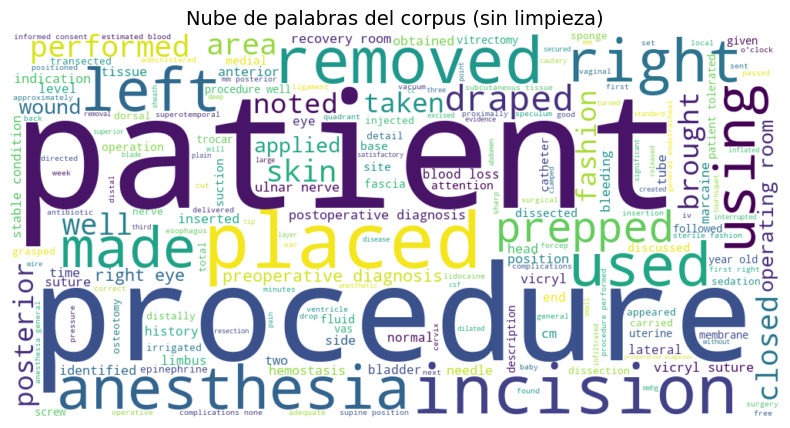

In [ ]:
# Wordcloud
wordcloud = WordCloud(width=1000, height=500, background_color='white').generate(corpus)

# Mostrar la nube de palabras
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Nube de palabras del corpus (sin limpieza)", fontsize=14)
plt.show()

# 3. Análisis exploratorio del vocabulario
Del analisis de la nube de palabras generada, se concluye:  
- El corpus presenta una clara predominancia de términos como “patient”, “procedure”, “removed”, “placed”, “left”, “incision” y “anesthesia”, lo que podria reflejar la escritura repetitiva y semi extructurada de las transcripciones medicas. 
- El desbalance podria limitar la capacidad del modelo, favoreciendo el contenido  mas representado sobre el mas infrecuente (terminos medicos tecnicos, e infrecuentes)

# 4. Construcción del dataset de entrenamiento y validación

In [6]:
# Tamaño de contexto
max_context_size = 100

# Proporción para los datos de validación
p_val = 0.1
num_val = int(np.ceil(len(tokenized_text) * p_val / max_context_size))

# Dividir
train_text = tokenized_text[:-num_val * max_context_size]
val_text = tokenized_text[-num_val * max_context_size:]

# Validación: secuencias fijas
tokenized_sentences_val = [val_text[i * max_context_size:(i+1) * max_context_size] for i in range(num_val)]

# Entrenamiento: secuencias deslizantes
tokenized_sentences_train = [train_text[i:i + max_context_size] for i in range(len(train_text) - max_context_size + 1)]

# Crear X e y para entrenamiento (entrada y target desplazados en 1)
X = np.array(tokenized_sentences_train[:-1])
y = np.array(tokenized_sentences_train[1:])

print("Forma de X:", X.shape)
print("Forma de y:", y.shape)

Forma de X: (89466, 100)
Forma de y: (89466, 100)


## 5. Definición del Modelo

**Arquitectura:** una capa de embedding, dos capas LSTM y una capa de salida densa con softmax.

- **Embedding (128):** Permite representar los caracteres con vectores densos de mayor dimensionalidad que el one-hot, mejorando la capacidad del modelo para captar patrones.
- **1° LSTM (128) y 2° LSTM (64):** Buscan mejorar la capacidad del modelo para aprender dependencias tanto de corto como de largo plazo, lo cual es especialmente útil en textos médicos donde se hace referencia a las mismas entidades o procedimientos en múltiples líneas.
- **Capa densa de salida (softmax sobre 43 caracteres)** 

**Parámetros entrenables:** 189.291

Se utiliza regularización mediante `dropout` y `recurrent_dropout` para mitigar el sobreajuste.  
La **perplejidad** se emplea como métrica principal para evaluar la calidad del modelo de lenguaje.

El entrenamiento se configuró con un máximo de **40 épocas**, pero se aplicó **early stopping** que detiene el proceso si no se observan mejoras en la perplejidad durante 5 épocas consecutivas.

In [7]:
def build_model(chars_vocab, rnn_type="LSTM", units_first_lstm=128, units_second_lstm=64, embedding_dim=64, dropout=0.2, rec_dropout=0.2):
    model = Sequential()
    
    # Capa de Embedding
    model.add(Embedding(input_dim=len(chars_vocab), output_dim=embedding_dim, input_shape=(None,)))

    # Seleccionar la celda recurrente
    if rnn_type == "SimpleRNN":
        model.add(SimpleRNN(units_first_lstm, return_sequences=True, dropout=dropout, recurrent_dropout=rec_dropout))
    elif rnn_type == "LSTM":
        # Primera capa LSTM
        model.add(LSTM(units_first_lstm, return_sequences=True, dropout=dropout, recurrent_dropout=rec_dropout))
        # Segunda capa LSTM
        model.add(LSTM(units_second_lstm, return_sequences=True, dropout=dropout, recurrent_dropout=rec_dropout))
    elif rnn_type == "GRU":
        model.add(GRU(units_first_lstm, return_sequences=True, dropout=dropout, recurrent_dropout=rec_dropout))
    else:
        raise ValueError("Tipo de RNN desconocido. Seleccione 'SimpleRNN', 'LSTM' o 'GRU'.")

    model.add(Dense(len(chars_vocab), activation='softmax'))
    model.compile(loss='sparse_categorical_crossentropy', optimizer='rmsprop')
    model.summary()
    return model

# Configuracion
units_primera_capa = 128  
units_segunda_capa = 64   
embedding_dimension = 128 
model = build_model(chars_vocab=chars_vocab, rnn_type="LSTM",
                    units_first_lstm=units_primera_capa, units_second_lstm=units_segunda_capa,
                    embedding_dim=embedding_dimension)

c:\PythonEnvs\PNL\Lib\site-packages\keras\src\layers\core\embedding.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, None, 128)      │         5,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, None, 128)      │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, None, 64)       │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, None, 43)       │         2,795 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 189,291 (739.42 KB)

 Trainable params: 189,291 (739.42 KB)

 Non-trainable params: 0 (0.00 B)

## 6. Callback para Perplejidad

In [8]:
class ValDataGenerator(Sequence):
    def __init__(self, X, batch_size):
        self.X = X
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.X) / self.batch_size))

    def __getitem__(self, idx):
        batch_x = self.X[idx * self.batch_size : (idx + 1) * self.batch_size]
        return batch_x

class PplCallback(keras.callbacks.Callback):
    '''
    Callback para calcular la perplejidad al final de cada época y aplicar early stopping si no mejora.
    '''
    def __init__(self, val_data, history_ppl, patience=5, batch_size=1024):
        self.val_data = val_data
        self.history_ppl = history_ppl
        self.patience = patience
        self.batch_size = batch_size

        self.target = []
        self.padded = []
        self.info = []

        count = 0
        self.min_score = np.inf
        self.patience_counter = 0

        for seq in self.val_data:
            len_seq = len(seq)
            subseq = [seq[:i] for i in range(1, len_seq)]
            self.target.extend([seq[i] for i in range(1, len_seq)])
            if subseq:
                self.padded.append(pad_sequences(subseq, maxlen=max_context_size, padding='pre'))
                self.info.append((count, count + len_seq - 1))
                count += len_seq - 1
        self.padded = np.vstack(self.padded)

    def on_epoch_end(self, epoch, logs=None):
        print("\n[Callback] Calculando perplejidad...")
        try:
            predictions = self.model.predict(ValDataGenerator(self.padded, self.batch_size), verbose=0)
        except Exception as e:
            print(f"[Error] Falló predict(): {e}")
            self.model.stop_training = True
            return

        scores = []
        try:
            for start, end in self.info:
                probs = []
                for idx_seq, idx_vocab in zip(range(start, end), self.target[start:end]):
                    prob = predictions[idx_seq, -1, idx_vocab]
                    prob = np.clip(prob, 1e-10, 1.0)
                    probs.append(prob)
                ppl = np.exp(-np.sum(np.log(probs)) / (end - start))
                scores.append(ppl)

            current_score = np.mean(scores)
            self.history_ppl.append(current_score)
            print(f'\n📉 Perplejidad media: {current_score:.4f}')

            if current_score < self.min_score:
                self.min_score = current_score
                self.model.save("my_model.keras")
                print("✅ Nuevo modelo guardado.")
                self.patience_counter = 0
            else:
                self.patience_counter += 1
                print(f"⚠️ No mejora. Paciencia: {self.patience_counter}/{self.patience}")
                if self.patience_counter >= self.patience:
                    print("🛑 Early stopping activado.")
                    self.model.stop_training = True
        except Exception as e:
            print(f"[Error] Falló cálculo de perplejidad: {e}")
            self.model.stop_training = True

## 7. Entrenamiento del Modelo

In [ ]:
history_ppl = []

# Inicializar el callback con los datos de validación
callback = PplCallback(tokenized_sentences_val, history_ppl, patience=5)

# # Entrenamiento con 40 épocas
epochs = 40
hist = model.fit(X, y, epochs=epochs, batch_size=256, callbacks=[callback])

Epoch 1/40
350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 867ms/step - loss: 3.0168
[Callback] Calculando perplejidad...


c:\PythonEnvs\PNL\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()



📉 Perplejidad media: 14.1907
✅ Nuevo modelo guardado.
350/350 ━━━━━━━━━━━━━━━━━━━━ 316s 887ms/step - loss: 3.0164
Epoch 2/40
350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 828ms/step - loss: 2.5328
[Callback] Calculando perplejidad...

📉 Perplejidad media: 10.2460
✅ Nuevo modelo guardado.
350/350 ━━━━━━━━━━━━━━━━━━━━ 293s 838ms/step - loss: 2.5326
Epoch 3/40
350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 727ms/step - loss: 2.2381
[Callback] Calculando perplejidad...

📉 Perplejidad media: 8.3393
✅ Nuevo modelo guardado.
350/350 ━━━━━━━━━━━━━━━━━━━━ 258s 737ms/step - loss: 2.2380
Epoch 4/40
350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 713ms/step - loss: 2.0595
[Callback] Calculando perplejidad...

📉 Perplejidad media: 7.3613
✅ Nuevo modelo guardado.
350/350 ━━━━━━━━━━━━━━━━━━━━ 253s 722ms/step - loss: 2.0594
Epoch 5/40
350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 694ms/step - loss: 1.9421
[Callback] Calculando perplejidad...

📉 Perplejidad media: 6.7629
✅ Nuevo modelo guardado.
350/350 ━━━━━━━━━━━━━━━━━━━━ 246s 704ms/step - loss: 1.9420
Epoc

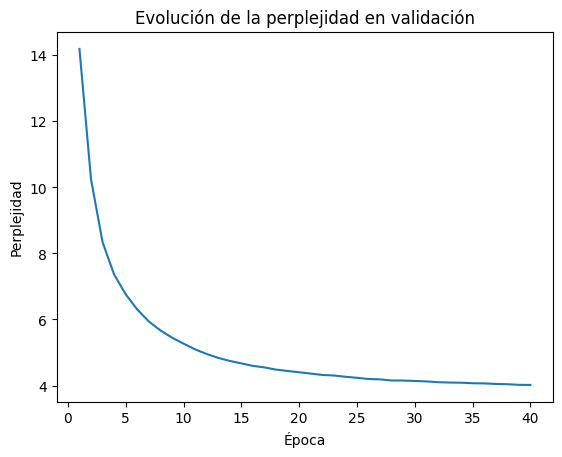

In [ ]:
# Gráfico de desempeño - Perplejidad por época
epoch_count = range(1, len(history_ppl) + 1)
sns.lineplot(x=list(epoch_count), y=history_ppl)
plt.xlabel("Época")
plt.ylabel("Perplejidad")
plt.title("Evolución de la perplejidad en validación")
plt.show()

**Conclusión de entrenamiento:** 
- Sin señales de sobre ajuste. 
- Se observa tendencia descendente de loss en el entrenamiento y de la perplejidad en el conjunto de validación **(Inicio: 14.19 / Fin: 4.01)** de forma continua y sostenida.


## 8. Generación de Texto: 
#### 1) Greedy Search: En cada paso, se selecciona el carácter más probable dado el contexto actual.

In [9]:
# Se carga el mejor modelo guardado
model = load_model("my_model.keras")

def generate_seq(model, seed_text, max_length, n_words):
    output_text = seed_text
    for _ in range(n_words):
        # Solo usar caracteres que están en el vocabulario
        encoded = [char2idx[ch] for ch in output_text.lower() if ch in char2idx]
        encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')
        y_hat = np.argmax(model.predict(encoded, verbose=0)[0, -1, :])
        output_text += idx2char[y_hat]
    return output_text

input_texts = ["", "", "" ]

# Ejemplo de generación usando Greedy Search
input_text = "the patient was "
print("Generación Greedy:", generate_seq(model, input_text, max_context_size, n_words=70))

input_text = "the incision site "
print("Generación Greedy:", generate_seq(model, input_text, max_context_size, n_words=70))

input_text = "following the anesthesia, "
print("Generación Greedy:", generate_seq(model, input_text, max_context_size, n_words=70))

Generación Greedy: the patient was then inserted to the procedure , the patient was then inserted to the 
Generación Greedy: the incision site was then inserted to the procedure , the patient was then inserted to 
Generación Greedy: following the anesthesia, the patient was then inserted to the procedure , the patient was then 


**Conclusión de Greedy search:** 
- Debido a la falta de diversidad en Greedy Search, el modelo tiende a repetir estructuras comunes, cayendo en bucles que involucran las palabras mas frecuentes identificadas en la nube de palabras. 
- Para mitigar el efecto, se realizarán pruebas comparativas con **Beam Search Estocástico** y **Determinista**, configuradas de la siguiente manera:

Parámetros fijos (para ambos enfoques):
- num_beams = `5`
- num_words = `70`
- top-k = `15` (solo en el enfoque estocástico)

Parámetros variables:
- Temperatura: `0.8` y `1.4` (solo para el enfoque estocástico)
- Penalidad n-gram (3-gram / 4-gram): `0` y `1` (para ambos enfoques)


#### 2)  Beam Search

In [ ]:
# Parametros a configurar
input_texts = [
    "the patient was ",
    "the incision site ",
    "following the anesthesia, "
]
num_beams = 5
num_words = 70
penalty_configs = [
    (0.0, 0.0),  # sin penalización
    (1.0, 1.0),  # ambos
]
temps = [0.8, 1.4]
top_k = 15

# Funciones auxiliares

def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / np.sum(e_x)

def encode(text, max_length=max_context_size):
    encoded = [char2idx[ch] for ch in text]
    return pad_sequences([encoded], maxlen=max_length, padding='pre')

def decode(seq):
    return ''.join(idx2char[ch] for ch in seq)

def select_candidates(pred, num_beams, vocab_size, history_probs, history_tokens,
                      history_trigrams, history_fourgrams, temp, mode,
                      penalty_trigram, penalty_fourgram, top_k=None):
    scores, candidates = [], []
    for i, p in enumerate(pred):
        top_ids = np.argsort(p)[-top_k:][::-1] if (mode == 'sto' and top_k) else range(vocab_size)
        for tok in top_ids:
            prob = p[tok]
            score = np.log(prob + 1e-10) + history_probs[i]
            hist = history_tokens[i]
            if len(hist) >= 2 and (hist[-2], hist[-1], tok) in history_trigrams[i]:
                score -= penalty_trigram
            if len(hist) >= 3 and (hist[-3], hist[-2], hist[-1], tok) in history_fourgrams[i]:
                score -= penalty_fourgram
            scores.append(score)
            candidates.append((i, tok))
    scores = np.array(scores)
    if mode == 'det':
        sel = np.argsort(scores)[::-1][:num_beams]
    else:
        probs = softmax(scores / temp)
        sel = np.random.choice(len(scores), num_beams, replace=False, p=probs)
    new_probs, new_tokens, new_trigrams, new_fourgrams = [], [], [], []
    for idx in sel:
        bi, tok = candidates[idx]
        seq = np.concatenate([history_tokens[bi], [tok]])
        new_probs.append(scores[idx])
        new_tokens.append(seq)
        tri = history_trigrams[bi].copy()
        if len(seq) >= 3:
            tri.add(tuple(seq[-3:]))
        new_trigrams.append(tri)
        quad = history_fourgrams[bi].copy()
        if len(seq) >= 4:
            quad.add(tuple(seq[-4:]))
        new_fourgrams.append(quad)
    return np.array(new_probs), new_tokens, new_trigrams, new_fourgrams

# Beam Search

def beam_search(model, num_beams, num_words, input_text, temp=1, mode='det',
                penalty_trigram=0.0, penalty_fourgram=0.0, top_k=None):
    print(f"Starting beam_search: mode={mode}, temp={temp}, top_k={top_k}")
    encoded = encode(input_text)
    vocab_size = model.predict(encoded, verbose=0)[0, -1, :].shape[0]
    history_probs = [0.0] * num_beams
    history_tokens = [encoded[0].tolist() for _ in range(num_beams)]
    history_trigrams = [set(tuple(encoded[0][i:i+3]) for i in range(len(encoded[0]) - 2)) for _ in range(num_beams)]
    history_fourgrams = [set(tuple(encoded[0][i:i+4]) for i in range(len(encoded[0]) - 3)) for _ in range(num_beams)]
    
    print(f" - Expansión inicial para '{input_text}'")
    last_pred = model.predict(encoded, verbose=0)[0, -1, :]
    history_probs, history_tokens, history_trigrams, history_fourgrams = select_candidates(
        [last_pred], num_beams, vocab_size,
        history_probs, history_tokens,
        history_trigrams, history_fourgrams,
        temp, mode, penalty_trigram, penalty_fourgram, top_k
    )

    for step in range(1, num_words):
        preds = []
        for seq in history_tokens:
            inp = pad_sequences([seq[-max_context_size:]], maxlen=max_context_size, padding='pre')
            preds.append(model.predict(inp, verbose=0)[0, -1, :])
        history_probs, history_tokens, history_trigrams, history_fourgrams = select_candidates(
            preds, num_beams, vocab_size,
            history_probs, history_tokens,
            history_trigrams, history_fourgrams,
            temp, mode, penalty_trigram, penalty_fourgram, top_k
        )
    print("Beam search complete")
    return np.array(history_tokens)

# Determinista

def evaluate_beam_search_deterministic(model):
    """
    Ejecuta beam search determinista ('det') con distintas penalizaciones.
    """
    results = []
    for text in input_texts:
        for trigram_pen, fourgram_pen in penalty_configs:
            print(f"Evaluando DET: text='{text}', trigram_pen={trigram_pen}, fourgram_pen={fourgram_pen}")
            seqs = beam_search(
                model,
                num_beams=num_beams,
                num_words=num_words,
                input_text=text,
                mode='det',
                penalty_trigram=trigram_pen,
                penalty_fourgram=fourgram_pen
            )
            results.append({
                'mode': 'det',
                'input': text,
                'trigram_penalty': trigram_pen,
                'fourgram_penalty': fourgram_pen,
                'output': decode(seqs[0])
            })
    return pd.DataFrame(results)

# Estocastico

def evaluate_beam_search_stochastic(model):
    """
    Ejecuta beam search estocástico ('sto') con temperaturas, top_k y penalizaciones.
    """
    from itertools import product
    results = []
    for text, temp, (trigram_pen, fourgram_pen) in product(input_texts, temps, penalty_configs):
        print(f"Evaluando STO: text='{text}', temp={temp}, top_k={top_k}, trigram_pen={trigram_pen}, fourgram_pen={fourgram_pen}")
        seqs = beam_search(
            model,
            num_beams=num_beams,
            num_words=num_words,
            input_text=text,
            temp=temp,
            mode='sto',
            penalty_trigram=trigram_pen,
            penalty_fourgram=fourgram_pen,
            top_k=top_k
        )
        results.append({
            'mode': 'sto',
            'input': text,
            'temperature': temp,
            'top_k': top_k,
            'trigram_penalty': trigram_pen,
            'fourgram_penalty': fourgram_pen,
            'output': decode(seqs[0])
        })
    return pd.DataFrame(results)


def run_all_beam_search(model):
    print("\n>>> Iniciando evaluación completa Beam Search <<<")
    df_det = evaluate_beam_search_deterministic(model)
    df_sto = evaluate_beam_search_stochastic(model)
    print("\nResultados Beam Search Determinista:")
    print(df_det.to_string(index=False))
    print("\nResultados Beam Search Estocástico:")
    print(df_sto.to_string(index=False))
    return df_det, df_sto


In [ ]:
# Ejemplos
run_all_beam_search(model)


>>> Iniciando evaluación completa Beam Search <<<
Evaluando DET: text='the patient was ', trigram_pen=0.0, fourgram_pen=0.0
Starting beam_search: mode=det, temp=1, top_k=None
 - Expansión inicial para 'the patient was '
Beam search complete
Evaluando DET: text='the patient was ', trigram_pen=1.0, fourgram_pen=1.0
Starting beam_search: mode=det, temp=1, top_k=None
 - Expansión inicial para 'the patient was '
Beam search complete
Evaluando DET: text='the incision site ', trigram_pen=0.0, fourgram_pen=0.0
Starting beam_search: mode=det, temp=1, top_k=None
 - Expansión inicial para 'the incision site '
Beam search complete
Evaluando DET: text='the incision site ', trigram_pen=1.0, fourgram_pen=1.0
Starting beam_search: mode=det, temp=1, top_k=None
 - Expansión inicial para 'the incision site '
Beam search complete
Evaluando DET: text='following the anesthesia, ', trigram_pen=0.0, fourgram_pen=0.0
Starting beam_search: mode=det, temp=1, top_k=None
 - Expansión inicial para 'following the a

(  mode                       input  trigram_penalty  fourgram_penalty  \
 0  det            the patient was               0.0               0.0   
 1  det            the patient was               1.0               1.0   
 2  det          the incision site               0.0               0.0   
 3  det          the incision site               1.0               1.0   
 4  det  following the anesthesia,               0.0               0.0   
 5  det  following the anesthesia,               1.0               1.0   
 
                                                                                                                                                                        output  
 0                                                                                      the patient was prepped and draped in the patient was then removed.  the patient was t  
 1                                                                                      the patient was prepped and dissected.

## 9. Conclusiones:
#### 1) Beam search: Determinista

| mode | input                     | temperature | top_k | trigram_penalty | fourgram_penalty | output                                                                                  |
|------|---------------------------|-------------|--------|------------------|-------------------|------------------------------------------------------------------------------------------|
| det  | the patient was           | N/A         | N/A    | 0.0              | 0.0               | the patient was prepped and draped in the patient was then removed. the patient was t    |
| det  | the patient was           | N/A         | N/A    | 1.0              | 1.0               | the patient was prepped and dissected. a complications , none.,postoperative diagnosi    |
| det  | the incision site         | N/A         | N/A    | 0.0              | 0.0               | the incision site and the patient was then removed. the patient was then removed. the    |
| det  | the incision site         | N/A         | N/A    | 1.0              | 1.0               | the incision site was prepped and dissected with a complications , none.,postoperative d |
| det  | following the anesthesia, | N/A         | N/A    | 0.0              | 0.0               | following the anesthesia, the patient was then removed. the patient was placed in the procedure |
| det  | following the anesthesia, | N/A         | N/A    | 1.0              | 1.0               | following the anesthesia, and draped with a complications , none.,postoperative diagnoses,1. th |


Este método selecciona de forma sistemática las secuencias más probables haciéndolo propenso a generar patrones repetitivos similar a Greedy search cuando no se aplican restricciones adicionales.

**Efecto de las penalizaciones**

- Sin penalizaciones, las salidas mostraron **repeticiones marcadas y/o redundantes** Ejemplos:
    - Fila 1: *"the patient was*" → *"the patient was then removed. the patient was..."*
    - Fila 3: *"the incision site*" → *"then removed... then removed"*

- Con penalizaciones, se observó una clara mejora. **Menos repeticiones, introducción de terminología** medica relevante. Ejemplos:
    - Fila 2: *"prepped and dissected"*
    - Filas 2, 4 y 6: *"complications"*
    - Fila 6: *"postoperative diagnosis"*




#### 1) Beam search: Estocástico

| mode | input                     | temperature | top_k | trigram_penalty | fourgram_penalty | output                                                                                   |
|------|---------------------------|-------------|--------|------------------|-------------------|-------------------------------------------------------------------------------------------|
| sto  | the patient was           | 0.8         | 15     | 0.0              | 0.0               | the patient was then placed in the operating room in the ventricular catheter. the pa     |
| sto  | the patient was           | 0.8         | 15     | 1.0              | 1.0               | the patient was removed and draped with 0 vicryl suture.,postoperative diagnosis , ver    |
| sto  | the patient was           | 1.4         | 15     | 0.0              | 0.0               | the patient was then injected with a limated with a closed with a vitrectomy.,procedur    |
| sto  | the patient was           | 1.4         | 15     | 1.0              | 1.0               | the patient was closed with been approximately to be incision. a vaginal sutures. it      |
| sto  | the incision site         | 0.8         | 15     | 0.0              | 0.0               | the incision site was then then removed with the patient was placed in the level of the   |
| sto  | the incision site         | 0.8         | 15     | 1.0              | 1.0               | the incision site was brought eye.,description, and draped with 0 vicryl sclerotomy were  |
| sto  | the incision site         | 1.4         | 15     | 0.0              | 0.0               | the incision site and removed and the operative to the left the patient was then made in  |
| sto  | the incision site         | 1.4         | 15     | 1.0              | 1.0               | the incision site and closed with was made to be directed. a brought to this stable lim   |
| sto  | following the anesthesia, | 0.8         | 15     | 0.0              | 0.0               | following the anesthesia, the patient was then placed in the patient was inserted to the patient |
| sto  | following the anesthesia, | 0.8         | 15     | 1.0              | 1.0               | following the anesthesia, this was prepped and dissected to be infiltrated with closed. she he |
| sto  | following the anesthesia, | 1.4         | 15     | 0.0              | 0.0               | following the anesthesia, the completely procedure was then prepped and draped in the proximal f |
| sto  | following the anesthesia, | 1.4         | 15     | 1.0              | 1.0               | following the anesthesia, and procedure was identified to be removed. the patient's medially, l |


A diferencia del *beam search*, este método favorece la diversidad en las secuencias generadas, permitiendo explorar frases menos probables. Las penalizaciones por repeticiones (3-gram y 4-gram) siguen siendo útiles

**Efecto de la temperatura**

- Temperatura 0.8: Las salidas tienden a mantener cierta estructura médica, especialmente cuando se aplican penalizaciones.
  - Ejemplo con penalización:  
    *"removed and draped with 0 vicryl suture, postoperative diagnosis..."*z
    *"draped with 0 vicryl sclerotomy were..."*

- Temperatura 1.4: Secuencias más creativas, pero también más inconsistentes
  - Ejemplo con penalización:  
    *"closed with been approximately to be incision..."* 


**Nota final:** Es evidente de que al tratarse de texto semi estructurado, es fundamental continuar mejorando el pre-procesamiento del datset. Esto evitaría variaciones, ambigüedades y repeticiones características de la estructura que pueden afectar la calidad del modelo
